## インポート

In [60]:
# パッケージの読み込み
import pandas as pd
import numpy as np
import datetime as dt
import time
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', 500)

# 前処理

## **欠損値処理**

**class: TypeChecker()**: 型をチェックするクラス\
**is_numeric(column)**: そのカラムのdtypeが数字型であるかどうか\
**is_boolean(column)**: そのカラムのdtypeがブール型であるかどうか\
**is_string(column)**: そのカラムのdtypeが文字列型であるかどうか

In [12]:
# dependency
# -pandas
class TypeChecker():
  def __init__(self):
    self.numeric_columns = ["int8","int16","int32","int64","uint8","uint16","uint32","uint64","float8","float16","float32","float64", "int", "uint", "float"]
    self.boolean_columns = ["bool"]
    self.string_columns = ["object", "str"]
    self.date_columns = ["datetime64[ns]"]
  def is_numeric(self, column):
    return column in self.numeric_columns
  def is_boolean(self, column):
    return column in self.boolean_columns
  def is_string(self, column):
    return column in self.date_columns

# sample
df = pd.read_csv('https://raw.githubusercontent.com/blue-eagle/estyle_data/master/day1_yc_data.csv',parse_dates=['date'], index_col=0).sort_index()
df["a"] = "a"

tc = TypeChecker()
tc.is_string(df["a"].dtype)
tc.is_boolean(df["holiday"].dtype)

True

**class: PreprocessForNull()**: null値に対しての処理をするクラス\
**drop_na_index(columns)**: columnsに対してnan値があった場合、その行を消去する\
**drop_na_index_all()**: nan値がある行を消去する\
**drop_na_column_all()**: nan値がある列を消去する\
**fill_na_by_value(columns, value)**: 任意のcolumnsに対してnan値を任意の値valueで補完する\
**fill_na_by_mean(columns, value)**: 任意のcolumnsに対してnan値を平均値で補完する\
**fill_na_by_mode(columns, value)**: 任意のcolumnsに対してnan値を最頻値で補完する\
**get_df(columns, value)**: 処理を終えたdfを取得する

In [15]:
# dependency
# -pandas
class PreprocessForNull():
  def __init__(self, df):
    self.df = df
  # nanを持つindexを消去
  def drop_na_index(self, columns):
    self.df = self.df.dropna(subset=columns)
  def drop_na_index_all(self):
    self.df = self.df.dropna()
  def drop_na_column_all(self):
    self.df = self.df.dropna(axis=1)
  def fill_na_by_value(self, columns, value=0):
    self.df[columns] = self.df[columns].fillna(value)
  def fill_na_by_mean(self, columns):
    self.df[columns] = self.df[columns].fillna(self.df[columns].mean())
  def fill_na_by_mode(self, columns):
    self.df[columns] = self.df[columns].fillna(self.df[columns].mode().iloc[0])
  def get_df(self):
    return self.df

# sample
df = pd.read_csv('https://raw.githubusercontent.com/blue-eagle/estyle_data/master/day1_yc_data.csv',parse_dates=['date'], index_col=0).sort_index()
df["a"] = np.nan
df['a'].iloc[0] = 3
df['a'].iloc[1] = 4
df['a'].iloc[2] = 4
pfn = PreprocessForNull(df)
pfn.fill_na_by_mean(["a"])
df = pfn.get_df()
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,num_rides,holiday,Max_Temp,Min_Temp,Rain_in,Snow&Hail_in,obs_time_ Snow&Hail_in,a
date,,,,,,,,
2017-01-01,281263.0,False,48,40,0.001,0.000,0.0,3.000000
2017-01-02,224893.0,True,41,37,0.210,0.001,0.0,4.000000
2017-01-03,278099.0,False,43,39,0.580,0.000,0.0,4.000000
2017-01-04,289301.0,False,52,34,0.000,0.000,0.0,3.666667
2017-01-05,324421.0,False,34,27,0.000,0.000,0.0,3.666667


## encoding

**get_scaled_by_column(df, target_columns, scaler=StandardScaler(), inplace=False, fit=True, transform=True):** : df 内の任意の column を scaler によってスケーリングする

In [16]:
# dependency
# - pandas
# - sklearn.preprocessing.<xxxx> (ex: StandardScaler)
def get_scaled_column(df, target_columns, scaler=StandardScaler(), inplace=False, fit=True, transform=True):
  DF = df.copy()
  arr = DF[target_columns].copy()
  if fit == True: scaler.fit(arr)
  if transform == True: arr = scaler.transform(arr)
  if inplace == True: DF[target_columns] = arr
  else:
    for idx, column in enumerate(target_columns):
      DF[f'scaled_{column}'] = arr.T[idx]
  return DF, scaler

# sample
df = pd.read_csv('https://raw.githubusercontent.com/blue-eagle/estyle_data/master/day1_yc_data.csv',parse_dates=['date'], index_col=0).sort_index()
DF, scaler = get_scaled_column(df, ["num_rides", "Max_Temp"])
DF, scaler = get_scaled_column(DF, ["scaled_num_rides", "scaled_Max_Temp"], scaler=scaler, fit=True)

**one_hot_encoding_by_target_column(df, category_column)** : df 内の任意の category_column を OneHotEncoder で dummy変数にして、そのdata frameおよび新たな column を返す

In [13]:
# dependency
# - pandas
# - sklearn.preprocessing.OneHotEncoder
class OneHotEncoding():
  def __init__(self, df, columns):
    self.df = df
    self.ohe = OneHotEncoder(sparse=False, categories='auto')
    self.columns = columns

  def fit(self):
    self.ohe.fit(self.df[self.columns])

  def transform(self):
    return self.ohe.transform(self.df[self.columns])

  def fit_transform_and_get_new_df(self, drop=True):
    self.ohe.fit(self.df[self.columns])
    new_columns = []
    for i, col in enumerate(self.columns):
      new_columns += [f'{col}_{v}' for v in self.ohe.categories_[i]]
    
    ndf = pd.DataFrame(self.ohe.transform(self.df[self.columns]), columns=new_columns, index=self.df.index)
    ndf = pd.concat([self.df, ndf], axis=1)
    if drop == True: ndf.drop(columns=self.columns, inplace=True)
    return ndf

  def transform_and_get_new_df(self):
    new_columns = []
    for i, col in enumerate(self.columns):
      new_columns += [f'{col}_{v}' for v in self.ohe.categories_[i]]

    ndf = pd.DataFrame(self.ohe.transform(self.df[self.columns]), columns=new_columns, index=self.df.index)
    ndf = pd.concat([self.df, ndf], axis=1)
    if drop == True: ndf.drop(columns=self.columns, inplace=True)
    return ndf

# sample
df = pd.read_csv('https://raw.githubusercontent.com/blue-eagle/estyle_data/master/day1_yc_data.csv',parse_dates=['date'], index_col=0).sort_index()
df["d"] = "s"
df["d"].iloc[0]="a"
df["e"] = "s"
df["f"] = "s"
ohefd = OneHotEncoding(df, ["d", "e", "f", "holiday"])
df = ohefd.fit_transform_and_get_new_df()
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,num_rides,Max_Temp,Min_Temp,Rain_in,Snow&Hail_in,obs_time_ Snow&Hail_in,d_a,d_s,e_s,f_s,holiday_False,holiday_True
date,,,,,,,,,,,,
2017-01-01,281263.0,48,40,0.001,0.000,0.0,1.0,0.0,1.0,1.0,1.0,0.0
2017-01-02,224893.0,41,37,0.210,0.001,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2017-01-03,278099.0,43,39,0.580,0.000,0.0,0.0,1.0,1.0,1.0,1.0,0.0
2017-01-04,289301.0,52,34,0.000,0.000,0.0,0.0,1.0,1.0,1.0,1.0,0.0
2017-01-05,324421.0,34,27,0.000,0.000,0.0,0.0,1.0,1.0,1.0,1.0,0.0


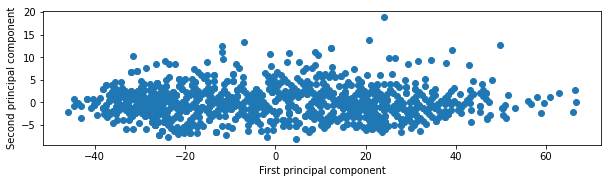

In [61]:
# dependency
# - pandas
# - PreprocessForNull <- 自作
# - OneHotEncoding <- 自作
# - TypeChecker <- 自作
# - sklearn.decomposition.PCA
# - sklearn.preprocessing.SandardScaler
# - matplotlib.pyplot

class PrincipalComponentAnalysis():
  def __init__(self, df, column_number):
    self.df = df
    self.column_number = column_number
    self.pca = PCA(n_components=column_number)

  def build(self):
    pfn = PreprocessForNull(self.df)
    type_checker = TypeChecker()
    category_columns = []
    for column in list(self.df.columns):
      dtype = self.df[column].dtype
      if type_checker.is_numeric(dtype):
        pfn.fill_na_by_mean(column)
      if type_checker.is_boolean(dtype):
        pfn.drop_na_index([column])
        category_columns.append(column)
      if type_checker.is_string(dtype):
        pfn.drop_na_index(column)
        category_columns.append(column)
    ohe = OneHotEncoding(pfn.df, category_columns)
    self.df = ohe.fit_transform_and_get_new_df()

  def fit(self):
    self.pca.fit(self.df)

  def build_fit(self):
    self.build()
    self.fit()

  def transform(self):
    return self.pca.transform(self.df)

  # fitしている必要がある
  def show_bar(self):
    plt.bar([n for n in range(1, len(self.pca.explained_variance_ratio_)+1)], self.pca.explained_variance_ratio_)

  def two_dimentional_plot(self):
    plt.figure(figsize=(10,10))
    X_pca = self.transform()
    plt.scatter(X_pca[:,0], X_pca[:, 1])
    plt.gca().set_aspect('equal')
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')

# sample
df = pd.read_csv('https://raw.githubusercontent.com/blue-eagle/estyle_data/master/day1_yc_data.csv',parse_dates=['date'], index_col=0).sort_index()
pca = PrincipalComponentAnalysis(df.drop(columns="num_rides"), 4)
pca.build_fit()
# pca.show_bar()
pca.two_dimentional_plot()
# print(df)